In [13]:
import os
import evaluate
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from typing import List
import matplotlib.pyplot as plt

In [2]:
test_tgt_path = "data/raw/recipes/dev.tgt"
test_src_path = "data/raw/recipes/dev.src"
task = "recipes"
run = "eb6ah8_d6_c128_lr2e-4_v2"
is_ema = True
rouge = evaluate.load('rouge')

In [3]:
def load_from_lines(path):
    with open(path, 'r') as f:
        return [line.strip() for line in f]
    
def list_avg(l):
    return sum(l) / len(l)

In [4]:
test = {
    'src': load_from_lines(test_src_path),
    'tgt': load_from_lines(test_tgt_path)
}

In [5]:
results = []
for checkpoint in tqdm(["10000", "20000", "30000", "40000", "50000", "60000", "70000", "80000", "90000",
                   "100000", "110000", "120000", "130000", "140000", "150000", "160000", "170000", "180000",
                   "190000", "200000"], desc="checkpoints"):
    for is_ema in [True, False]:
        gen_data_path = f"my_output/{task}/{run}/gen/dev_{checkpoint}{'_ema' if is_ema else ''}"
        if not os.path.exists(gen_data_path):
            continue
        # for each file in this directory, compute rouge
        all_scores = {
            'rouge-1': [],
            'rouge-2': [],
            'rouge-l': [],
        }
        for gen_file in os.listdir(gen_data_path):
            gen = load_from_lines(os.path.join(gen_data_path, gen_file))
            scores = rouge.compute(
                        predictions=[g.strip() for g in gen],
                        references=test["tgt"][:len(gen)],
                    )
            all_scores['rouge-1'].append(scores['rouge1'])
            all_scores['rouge-2'].append(scores['rouge2'])
            all_scores['rouge-l'].append(scores['rougeL'])
        results.append({
            'run': run,
            'checkpoint': checkpoint,
            'ema': is_ema,
            # max
            'rouge-1-max': max(all_scores['rouge-1']),
            'rouge-2-max': max(all_scores['rouge-2']),
            'rouge-l-max': max(all_scores['rouge-l']),
            # average
            'rouge-1-avg': list_avg(all_scores['rouge-1']), 
            'rouge-2-avg': list_avg(all_scores['rouge-2']),
            'rouge-l-avg': list_avg(all_scores['rouge-l']),

        })
        
df = pd.DataFrame(results)
    

checkpoints: 100%|██████████| 20/20 [07:54<00:00, 23.72s/it]


In [14]:
# df.to_csv(f"my_output/{task}/{run}/eval/rouge.csv", index=False)
df = pd.read_csv(f"my_output/{task}/{run}/eval/rouge.csv")

In [6]:

def plot_rouge(df):
    fig, ax = plt.subplots()
    sns.lineplot(x="checkpoint", y="rouge-1-max", data=df, ax=ax)
    sns.lineplot(x="checkpoint", y="rouge-2-max", data=df, ax=ax)
    sns.lineplot(x="checkpoint", y="rouge-l-max", data=df, ax=ax)
    ax.legend(['rouge-1', 'rouge-2', 'rouge-l'])
    ax.set_title(f"Max of 10 generation Rouge Scores along Training")
    ax.set_xlabel("Checkpoint")
    ax.set_ylabel("Rouge Score")

    # Add dots and text annotations
    for index, row in df.iterrows():
        ax.plot(row['checkpoint'], row['rouge-1-max'], 'ro')
        ax.annotate(f"{row['rouge-1-max']:.2f}", (row['checkpoint'], row['rouge-1-max']), textcoords="offset points", xytext=(5,5), ha='center')

        ax.plot(row['checkpoint'], row['rouge-2-max'], 'go')
        ax.annotate(f"{row['rouge-2-max']:.2f}", (row['checkpoint'], row['rouge-2-max']), textcoords="offset points", xytext=(5,5), ha='center')

        ax.plot(row['checkpoint'], row['rouge-l-max'], 'bo')
        ax.annotate(f"{row['rouge-l-max']:.2f}", (row['checkpoint'], row['rouge-l-max']), textcoords="offset points", xytext=(5,5), ha='center')

    # make plot longer
    fig.set_figwidth(15)
    fig.set_figheight(5)

    return fig, ax


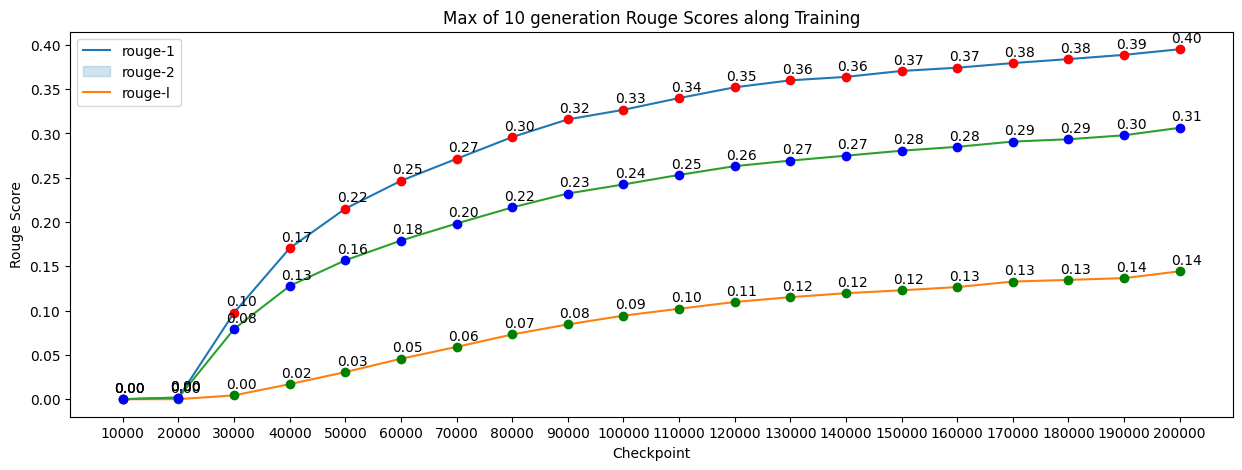

In [7]:
fig, ax = plot_rouge(df[df["ema"] == True]) 

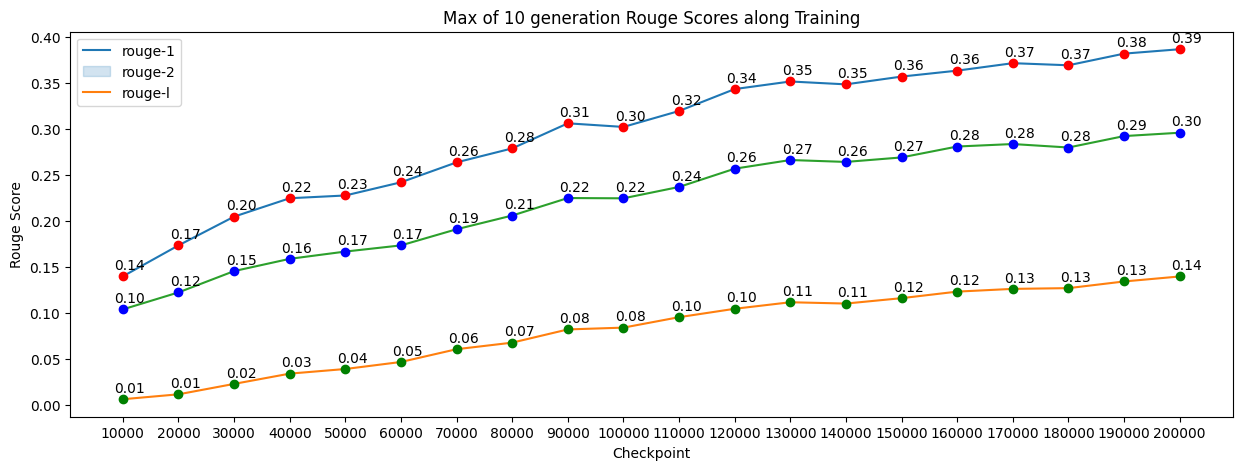

In [8]:
fig, ax = plot_rouge(df[df["ema"] == False]) 

In [42]:
# self bleu: https://github.com/geek-ai/Texygen/blob/3104e22ac75f3cc2070da2bf5e2da6d2bef149ad/utils/metrics/SelfBleu.py#L10

def compute_self_rouge(predictions: List, reference: str):
    rouge = evaluate.load('rouge')
    n = len(predictions)
    # self_metric = metric.compute(
    #     predictions=predictions*n, 
    #     references=[pred for pred in predictions for _ in range(n)]
    # )
    epsilon = 0.001
    self_metric = {
        'rouge1': 0,
        'rouge2': 0,
        'rougeL': 0,
    }
    weighted_self_metric = {
        'rouge1': 0,
        'rouge2': 0,
        'rougeL': 0,
    }
    for pred in predictions:
        self_rouge_score = rouge.compute(
            predictions=predictions,
            references=[pred for _ in range(n)],
        )
        rouge_score = rouge.compute(
            predictions=[pred],
            references=[reference],
        )
        for k in ['rouge1', 'rouge2', 'rougeL']:
            if rouge_score[k] < epsilon:
                rouge_score[k] = epsilon
            if self_rouge_score[k] < epsilon:
                self_rouge_score[k] = epsilon
            self_metric[k] += self_rouge_score[k]
            weighted_self_metric[k] += self_rouge_score[k]*(1/rouge_score[k])
    for k in ['rouge1', 'rouge2', 'rougeL']:
        self_metric[k] /= n
        weighted_self_metric[k] /= n
    print("self metrics: ", self_metric, weighted_self_metric)
    return self_metric, weighted_self_metric

In [44]:
results = []
for checkpoint in tqdm(["10000", "20000", "30000", "40000", "50000", "60000", "70000", "80000", "90000",
                   "100000", "110000", "120000", "130000", "140000", "150000", "160000", "170000", "180000",
                   "190000", "200000"][::-1], desc="checkpoints"):
    for is_ema in [True, False]:
        gen_data_path = f"my_output/{task}/{run}/gen/dev_{checkpoint}{'_ema' if is_ema else ''}"
        if not os.path.exists(gen_data_path):
            continue
        gens = []
        for gen_file in os.listdir(gen_data_path):
            gen = load_from_lines(os.path.join(gen_data_path, gen_file))
            gens.append(gen)
        all_scores = {
            'self_rouge-1': [],
            'self_rouge-2': [],
            'self_rouge-l': [],
            'weighted_self_rouge-1': [],
            'weighted_self_rouge-2': [],
            'weighted_self_rouge-l': [],
        }
        for i in range(len(gens[0])):
            predictions = [gen[i] for gen in gens]
            print(predictions, test["tgt"][i])
            self_metric, weighted_self_metric = compute_self_rouge(predictions, test["tgt"][i])
            all_scores['self_rouge-1'].append(self_metric['rouge1'])
            all_scores['self_rouge-2'].append(self_metric['rouge2'])
            all_scores['self_rouge-l'].append(self_metric['rougeL'])
            all_scores['weighted_self_rouge-1'].append(weighted_self_metric['rouge1'])
            all_scores['weighted_self_rouge-2'].append(weighted_self_metric['rouge2'])
            all_scores['weighted_self_rouge-l'].append(weighted_self_metric['rougeL'])
        
        all_scores = {k: list_avg(v) for k, v in all_scores.items()}

        results.append({
            'run': run,
            'checkpoint': checkpoint,
            'ema': is_ema,
            # self
            'self_rouge-1': all_scores['self_rouge-1'],
            'self_rouge-2': all_scores['self_rouge-2'],
            'self_rouge-l': all_scores['self_rouge-l'],
            # weighted self
            'weighted_self_rouge-1': all_scores['weighted_self_rouge-1'],
            'weighted_self_rouge-2': all_scores['weighted_self_rouge-2'],
            'weighted_self_rouge-l': all_scores['weighted_self_rouge-l'],
        })
        
df_self = pd.DataFrame(results)

checkpoints:   0%|          | 0/20 [00:00<?, ?it/s]

['2 ounces cold unsweet baking chocolate, chopped ( or more if thes of ) 3 / 16 cup white of the corn starch milk 3 / 4 cup of milk starch mix 2 cups heavy whipping cream 3 / 4 cup granulated sugar', "2 ounces, weight chocolate or baker't white chocolate ( about 2 - 1 cup ) 2 tablespoons corn starchch 4 1 / 2 cups milk about 2 cups heavy cream ( about 2 ounces ) 1 / 4 cup sugar", '1 ( 2 ounce ) package sweet chocolate, broken into small pieces, 1 cup of corn starch 2 cups milk 4 cups milk 3 / 4 cup heavy cream 1 / 2 to 2 cups heavy cream 1 granulated sugar', '4 ounces unsweet bittersweetened chocolate 4 ounces chocolate, finely chopped 1 / 2 cup corn starch 3 cup whole 2 cups milk 1 1 / 2 cups whipping cream 2 / 3 cup sugar 1 pinch of salt', '4 ounces chocolate baking chocolate or 1 cups chopped bittersweet chocolate ( or red ) cornstarch 6 cups 1 % milk, divided 1 / 2 cup milk or starch 1 cup heavy whipping cream 2 cups granulated sugar', '4 ounces semisweet chocolate pieces 4 ( 4 oun